# git clone

In [ ]:
!git clone https://github.com/jhj1111/DAGM2007_ws.git

Cloning into 'DAGM2007_ws'...
remote: Enumerating objects: 7032, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 7032 (delta 24), reused 39 (delta 13), pack-reused 6965 (from 2)
Receiving objects: 100% (7032/7032), 1.29 GiB | 29.92 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Updating files: 100% (6927/6927), done.


# dataset 분할

In [ ]:
import sys
sys.path.append('/content/DAGM2007_ws')

In [ ]:
!touch /content/DAGM2007_ws/yoloseg_datasets/__init__.py

In [ ]:
from DAGM2007_ws.yoloseg_datasets import create_segment_datasets

create_segment_datasets.DAGM_DATASET_DIR = '/content/DAGM2007_ws/DAGM_dataset'
create_segment_datasets.main()

# import

In [ ]:
# 기본 라이브러리 & PyTorch 모듈 임포트
import torch, random
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torchvision.transforms.functional as F
import os, cv2, glob, shutil
import zipfile
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report

base_dir = '/content'
# base_dir = r'C:\Users\HP\Documents\code_ws\vision_ws\DAGM2007'

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# learning rate와 데이터 학습
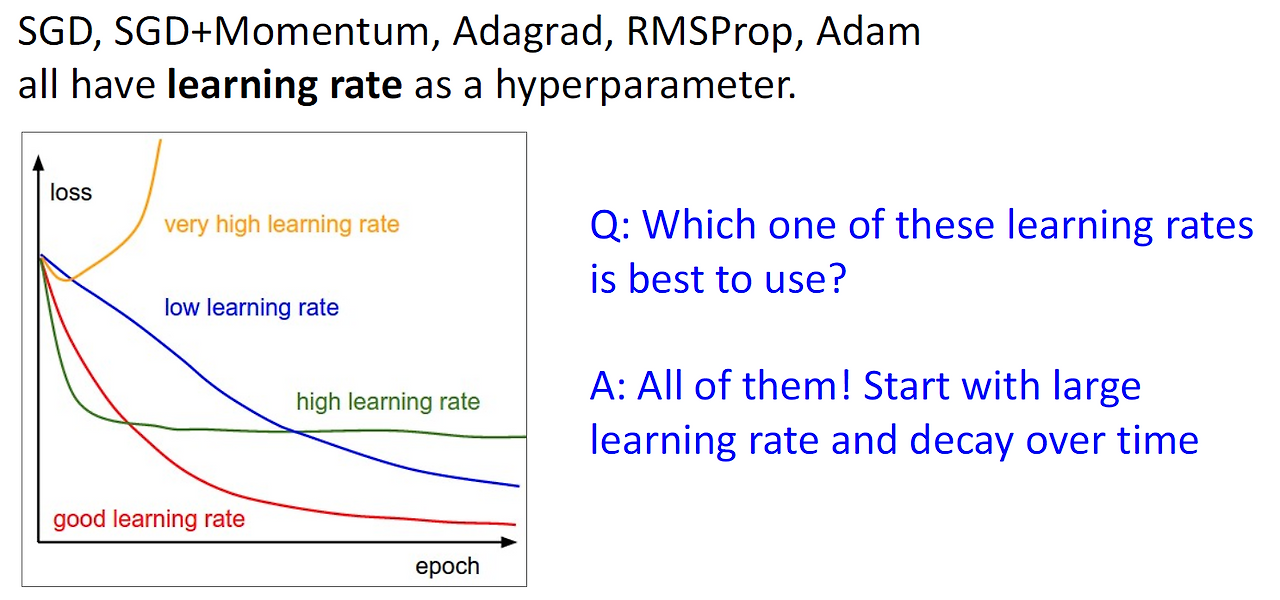

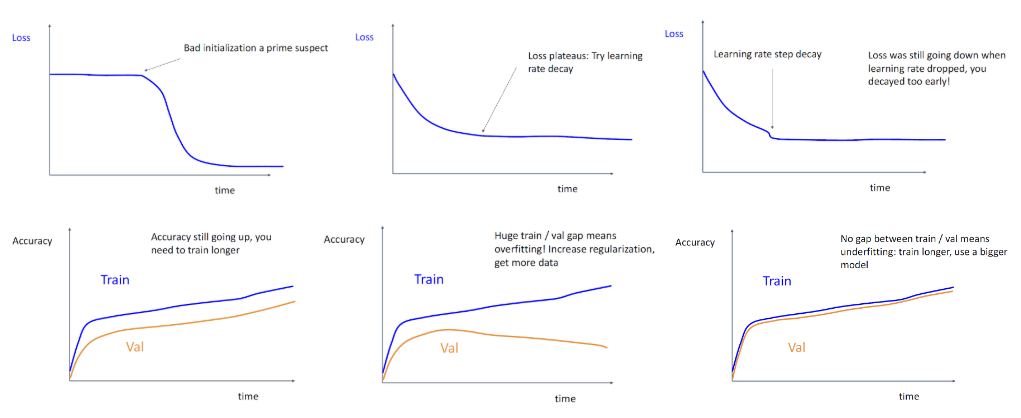

✅ 1. 기본 전제

| Task | 설명 |
| --- | --- |
| **Object Detection** | 객체 위치(box) + 클래스(class) 예측 |
| **Segmentation** | 픽셀 단위 객체 경계 예측 (box보다 fine) |

→ 즉, **segmentation은 detection보다 더 정밀한 예측이 필요**하기 때문에 학습 난이도도 높습니다.

---

✅ 2. 일반적인 Learning Rate 경향

| 항목 | Object Detection | Segmentation |
| --- | --- | --- |
| 초기 learning rate | 상대적으로 높게 설정 가능 (`1e-3`) | 보통 더 낮게 설정 (`1e-4` 또는 `1e-5`) |
| 안정성 | 빠르게 수렴하는 경향 | 과적합/진동 위험 있음 |
| 학습 수렴 시간 | 짧을 수 있음 | 더 오래 걸릴 수 있음 |
| augmentation 의존도 | moderate | 높음 (더 많은 데이터 다양성 필요) |
| LR 스케줄링 필요성 | 기본 사용 | **거의 필수적** (CosineDecay, OneCycle 등) |

---

✅ 3. 실전 세팅 예시 (YOLOv8 기준)

📦 Object Detection (`yolov8n.yaml`)

```bash
bash
복사편집
yolo task=detect model=yolov8n.yaml data=... lr0=0.01 epochs=50

```

🎯 Segmentation (`yolov8n-seg.yaml`)

```bash
bash
복사편집
yolo task=segment model=yolov8n-seg.yaml data=... lr0=0.001 epochs=100

```

- `lr0`: 초기 learning rate
- `segment` 모델은 `detect`보다 보통 **10배 낮은 lr0**에서 시작
- `epochs`는 더 길게 설정하는 경우 많음

---

✅ 4. 추천 세팅 요약

| Task | 추천 초기 Learning Rate (`lr0`) | Epochs | Scheduler |
| --- | --- | --- | --- |
| Detection | `1e-3 ~ 1e-2` | 50~100 | optional |
| Segmentation | `1e-4 ~ 5e-4` | 100~200 | ✅ 필요 (CosineDecay, OneCycle 등) |

---

✅ 결론

- **Segmentation은 더 낮은 learning rate와 더 긴 학습 시간**, 더 세심한 scheduler 조정이 필요합니다.
- YOLOv8의 세그멘테이션 학습 시 기본 `lr0=0.01`은 **과적합/진동 위험**이 있으므로 `0.001` 또는 그 이하로 낮추는 것이 안정적입니다.

# DAGM2007 YOLO train

In [ ]:
def accuracy(results):
  # test accuracy
  correct = 0
  correct_def_only = 0
  num_def = 0
  for result in results:
    if 'def' in result.path:
      num_def += 1
    if 'def' in result.path and result.boxes.conf.tolist():  # defect case
      correct += 1
      correct_def_only += 1
    elif 'def' not in result.path and not result.boxes.conf.tolist():
      correct += 1

  print('accuracy =', correct/len(results))
  print('def only accuracy =', correct_def_only/num_def)
  return correct/len(results)

## Class1 학습

### lr=0.003

custom_data.yaml 파일을 만들었으니 제대로 작성이 되었는지 확인합니다

yolov8을 인스톨합니다

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 754.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

yolov8이 제대로 설치가 되었는지 확인합니다

In [ ]:
import ultralytics

ultralytics.checks()

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 45.2/112.6 GB disk)


사전에 학습된 yolov8n.pt를 가져오고 적용시킵니다

yolov8의 학습파일은 yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt 등이 있습니다

In [ ]:
from ultralytics import YOLO

# Load a model
# model = YOLO("yolo11n-seg.yaml")  # build a new model from YAML
model = YOLO("yolo11n-seg.pt")  # load a pretrained model (recommended for training)
# model = YOLO("yolo11n-seg.yaml").load("yolo11n.pt")  # build from YAML and transfer weights

yolov8에서 사용하는 model이 yolov8n.pt 인지 확인해봅니다

yolov8은 cocodata의 분류를 가져서 80개의 name이 저장되어있습니다

In [ ]:
print(type(model.names),len(model.names))

print(model.names)

<class 'dict'> 80
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell p

우리가 원하는 데이터셋 경로를 가진 custom_data.yaml을 가지고 학습을 시작합니다

In [ ]:
model.train(data='/content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/data.yaml', epochs= 10, patience = 20, batch=32, imgsz =416, optimizer='Adam', lr0=.003)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True,

train: Scanning /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/labels/train... 919 images, 793 backgrounds, 0 corrupt: 100%|██████████| 919/919 [00:02<00:00, 357.85it/s]


train: New cache created: /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 35.0±8.1 MB/s, size: 225.9 KB)


val: Scanning /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/labels/val... 116 images, 107 backgrounds, 0 corrupt: 100%|██████████| 116/116 [00:00<00:00, 293.41it/s]

val: New cache created: /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/labels/val.cache


Plotting labels to runs/segment/train2/labels.jpg... 
optimizer: Adam(lr=0.003, momentum=0.937) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/segment/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.45G      3.202       4.27      11.73      2.188          0        416: 100%|██████████| 29/29 [00:14<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all        116          9          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.01G      2.972      3.614       2.98       2.18          4        416: 100%|██████████| 29/29 [00:11<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all        116          9          1      0.111      0.556      0.222          1      0.111      0.556     0.0556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.01G      2.869      3.055      2.279      2.021          3        416: 100%|██████████| 29/29 [00:10<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all        116          9          0          0          0          0    0.00662      0.111     0.0037    0.00037



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.04G      3.052      2.941      2.264      2.306          1        416: 100%|██████████| 29/29 [00:10<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all        116          9      0.809      0.444      0.602      0.197      0.603      0.778      0.785      0.282



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.05G      2.724      2.809      2.038      1.949          5        416: 100%|██████████| 29/29 [00:10<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all        116          9          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.07G      2.612      2.848      1.898      1.892          5        416: 100%|██████████| 29/29 [00:08<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all        116          9      0.627      0.561      0.679      0.264      0.842      0.444      0.622      0.277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.07G      2.506      2.688      2.093      1.812          0        416: 100%|██████████| 29/29 [00:09<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all        116          9      0.848      0.889      0.856      0.322      0.848      0.889      0.843        0.3



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.11G      2.446      2.707      1.687      1.799          4        416: 100%|██████████| 29/29 [00:10<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all        116          9       0.66      0.889      0.714      0.291       0.66      0.889      0.713      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.11G      2.437      2.796      1.669      1.763          4        416: 100%|██████████| 29/29 [00:10<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

                   all        116          9      0.741      0.889      0.821      0.397      0.741      0.889      0.821      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.13G      2.178      2.536      1.517      1.617          0        416: 100%|██████████| 29/29 [00:09<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all        116          9      0.758      0.889      0.865      0.419      0.758      0.889      0.865      0.369



10 epochs completed in 0.033 hours.
Optimizer stripped from runs/segment/train2/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train2/weights/best.pt, 6.0MB

Validating runs/segment/train2/weights/best.pt...
Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


                   all        116          9      0.755      0.889      0.865      0.419      0.755      0.889      0.865      0.369
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train2


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ba0ae464950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

(1200, 3600, 3)


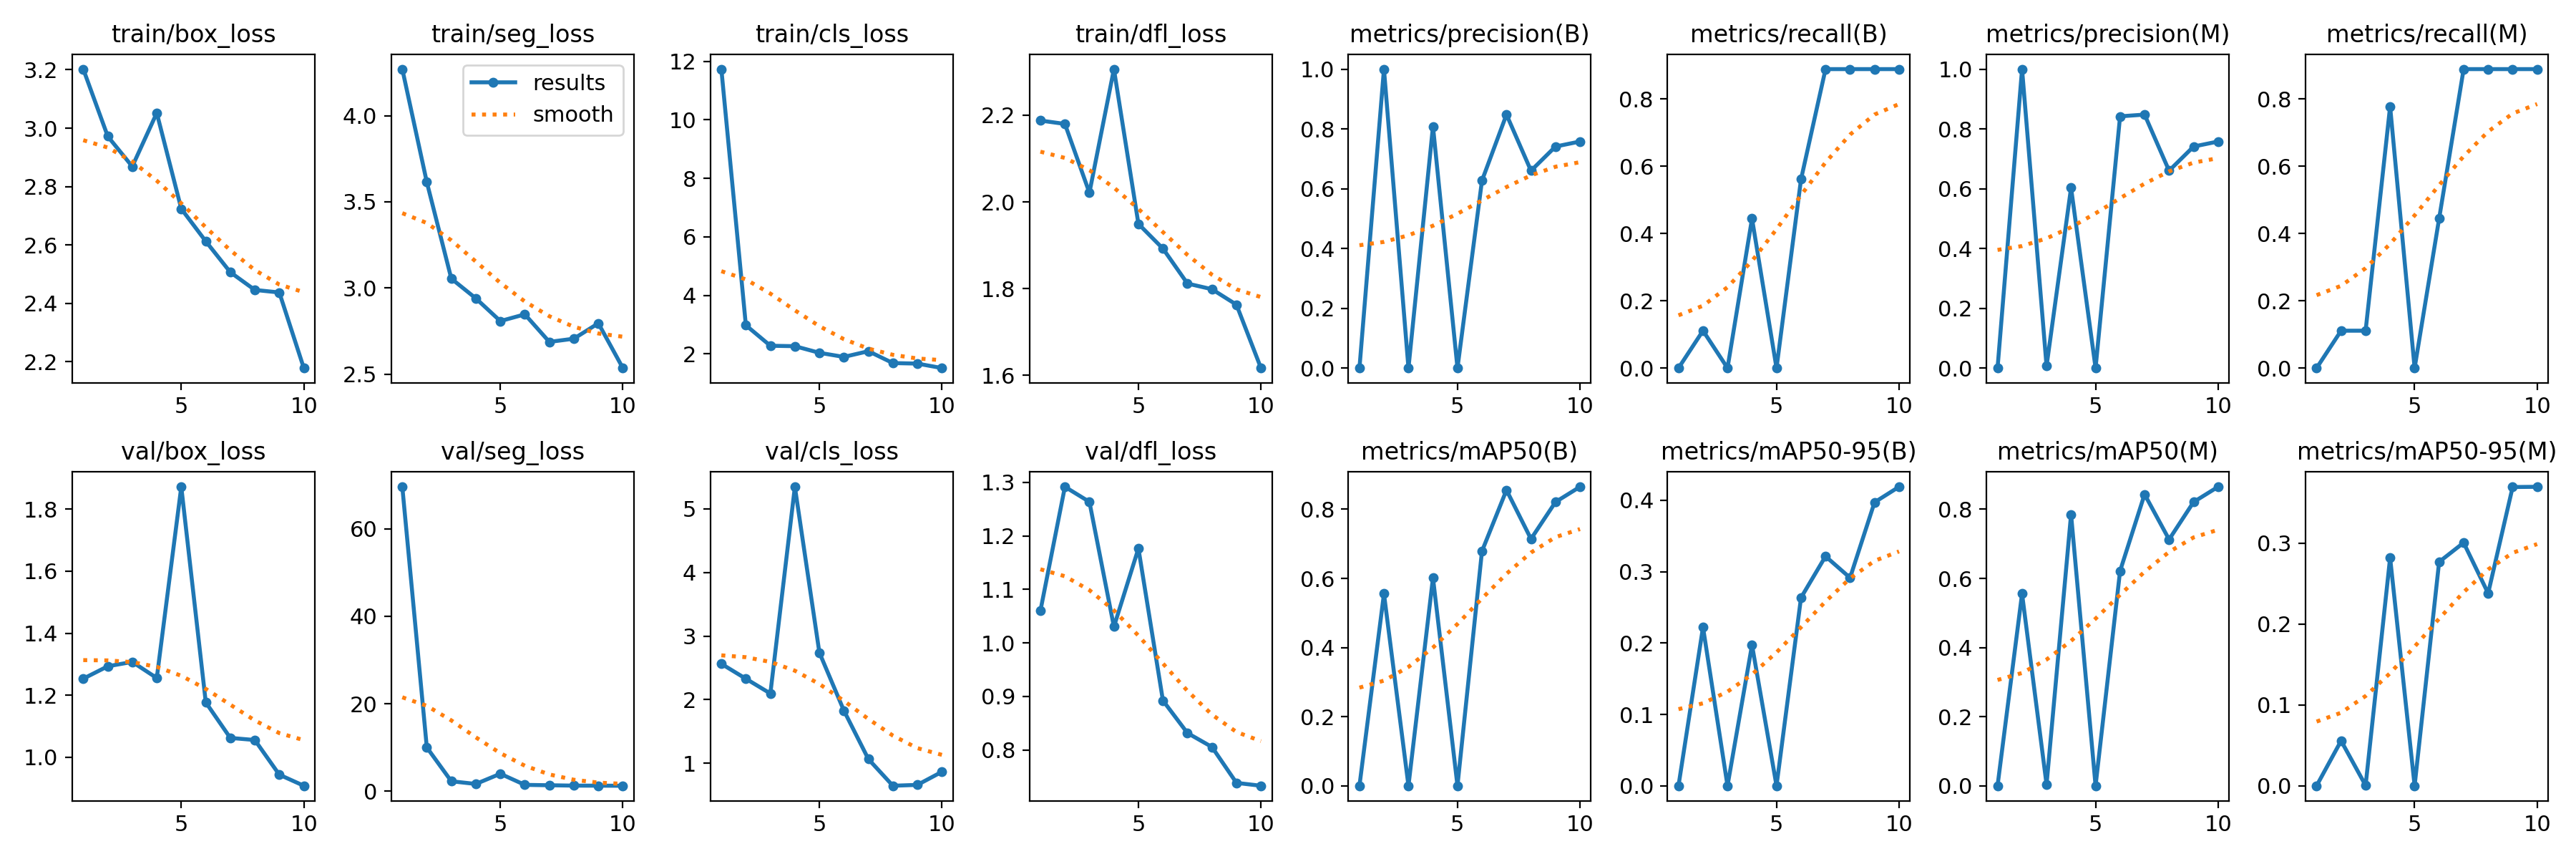

In [ ]:
from google.colab.patches import cv2_imshow

result_chart = cv2.imread('/content/runs/segment/train2/results.png')#, cv2.COLOR_RGB2BGR)
print(result_chart.shape)
cv2_imshow(result_chart)

학습한 결과 분석은 다음경로에 새롭게 저장되었습니다

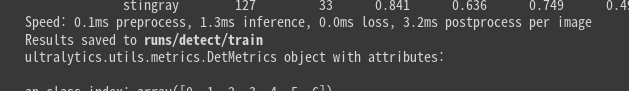

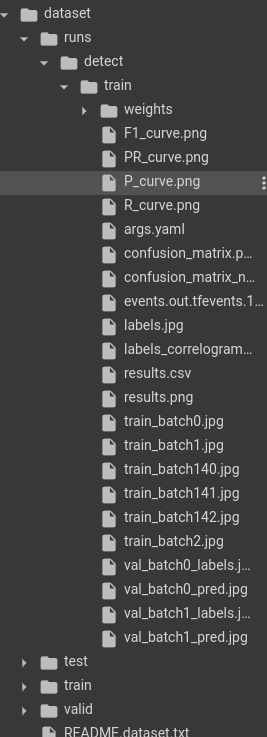

학습한 모델은 weights/best.pt 로 저장되어있습니다

yolov8은 학습하고 나서 자동적으로 모델을 변경합니다

실제로 변경되는지 확인합니다

In [ ]:
print(type(model.names),len(model.names))

print(model.names)

<class 'dict'> 1
{0: 'defect'}


학습된 결과물을 출력하는 부분입니다

마지막 출력문인 'Results saved to '이후에 나오는 경로가 학습된 이미지 출력이 있는 폴더의 경로입니다

image.png

In [ ]:
results = model.predict(source ='/content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test', save=True)


image 1/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test/009.png: 416x416 (no detections), 12.5ms
image 2/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test/021.png: 416x416 (no detections), 9.9ms
image 3/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test/025.png: 416x416 (no detections), 9.3ms
image 4/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test/050.png: 416x416 (no detections), 9.4ms
image 5/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test/069.png: 416x416 (no detections), 9.0ms
image 6/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test/071.png: 416x416 (no detections), 9.3ms
image 7/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test/091.png: 416x416 (no detections), 9.1ms
imag

In [ ]:
# test accuracy
_ = accuracy(results)

0.991304347826087


In [ ]:
results = model.predict(source ='/content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/train', save=True)


image 1/820 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/train/001.png: 416x416 (no detections), 40.9ms
image 2/820 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/train/002.png: 416x416 (no detections), 57.5ms
image 3/820 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/train/003.png: 416x416 (no detections), 40.4ms
image 4/820 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/train/004.png: 416x416 (no detections), 18.0ms
image 5/820 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/train/005.png: 416x416 (no detections), 17.5ms
image 6/820 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/train/006.png: 416x416 (no detections), 28.5ms
image 7/820 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/train/007.png: 416x416 (no detections)

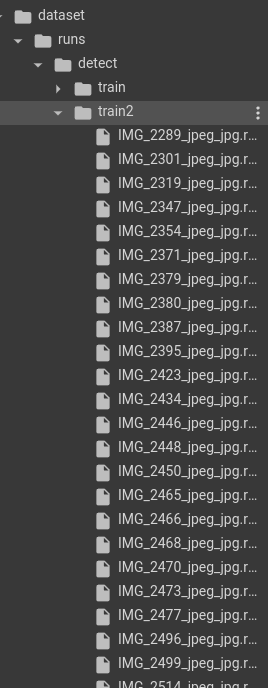

해당 경로에서 랜덤으로 이미지 출력을 보는 코드입니다

colab은 특수한 패키지를 사용해야 볼 수 있습니다

def_114.jpg


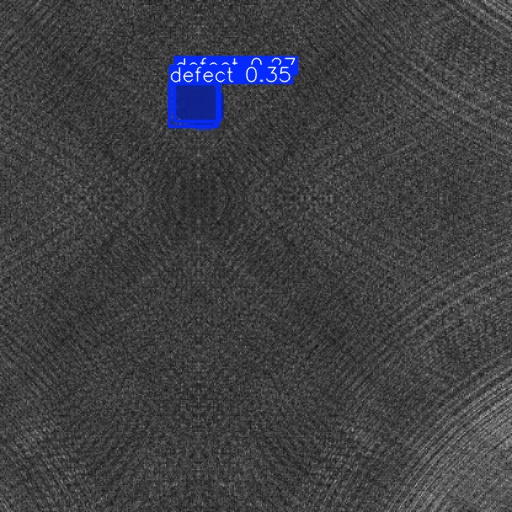

In [ ]:
# 이미지 파일 경로를 가져오기
image_paths = glob.glob('/content/runs/segment/train22/def_*.jpg')

# 이미지가 없는 경우 에러 처리
if not image_paths:
    print("이미지 파일이 없습니다.")
else:
    # 랜덤하게 이미지 선택
    selected_image_path = random.choice(image_paths)

    # 이미지 표시
    print(selected_image_path.split('/')[-1])
    img = cv2.imread(selected_image_path)
    cv2_imshow(img)

### lr=0.0005

In [ ]:
from ultralytics import YOLO

# Load a model
# model = YOLO("yolo11n-seg.yaml")  # build a new model from YAML
model = YOLO("yolo11n-seg.pt")  # load a pretrained model (recommended for training)
# model = YOLO("yolo11n-seg.yaml").load("yolo11n.pt")  # build from YAML and transfer weights

In [ ]:
print(type(model.names),len(model.names))

print(model.names)

<class 'dict'> 80
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell p

In [ ]:
model.train(data='/content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/data.yaml', epochs= 10, patience = 20, batch=32, imgsz =416, optimizer='Adam', lr0=.0005)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True

train: Scanning /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/labels/train.cache... 919 images, 793 backgrounds, 0 corrupt: 100%|██████████| 919/919 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 976.7±924.1 MB/s, size: 225.9 KB)


val: Scanning /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/labels/val.cache... 116 images, 107 backgrounds, 0 corrupt: 100%|██████████| 116/116 [00:00<?, ?it/s]


Plotting labels to runs/segment/train4/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/segment/train4
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.5G      3.117      4.031      11.65      2.087          0        416: 100%|██████████| 29/29 [00:12<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all        116          9          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.03G      2.711      3.277      3.356      1.758          4        416: 100%|██████████| 29/29 [00:13<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all        116          9          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.03G       2.63      2.949      2.285      1.882          3        416: 100%|██████████| 29/29 [00:12<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all        116          9        0.5      0.222      0.418      0.273          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.03G      2.525      2.824      1.923      1.851          1        416: 100%|██████████| 29/29 [00:10<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

                   all        116          9       0.28      0.778      0.429      0.195       0.28      0.778      0.429      0.151



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.03G      2.306      2.649      1.793      1.647          5        416: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]

                   all        116          9      0.102          1      0.904      0.391      0.102          1      0.814      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.03G      2.165      2.528      1.806      1.555          5        416: 100%|██████████| 29/29 [00:10<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all        116          9      0.524      0.856      0.748      0.261      0.653      0.778      0.671      0.227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.03G      2.137      2.388      1.952      1.502          0        416: 100%|██████████| 29/29 [00:10<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.26it/s]

                   all        116          9      0.765      0.889      0.939      0.453      0.655      0.778      0.823      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.06G      2.058      2.494      1.611      1.467          4        416: 100%|██████████| 29/29 [00:09<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all        116          9      0.801      0.896      0.963      0.414      0.801      0.896      0.963       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.06G      2.013       2.56       1.55      1.475          4        416: 100%|██████████| 29/29 [00:09<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all        116          9      0.999          1      0.995      0.438      0.999          1      0.995      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.06G      1.789      2.188       1.46      1.335          0        416: 100%|██████████| 29/29 [00:09<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all        116          9      0.855          1      0.973      0.457      0.855          1      0.973      0.451



10 epochs completed in 0.035 hours.
Optimizer stripped from runs/segment/train4/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train4/weights/best.pt, 6.0MB

Validating runs/segment/train4/weights/best.pt...
Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


                   all        116          9      0.856          1      0.973      0.457      0.856          1      0.973      0.451
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train4


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ba1060b7cd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

(1200, 3600, 3)


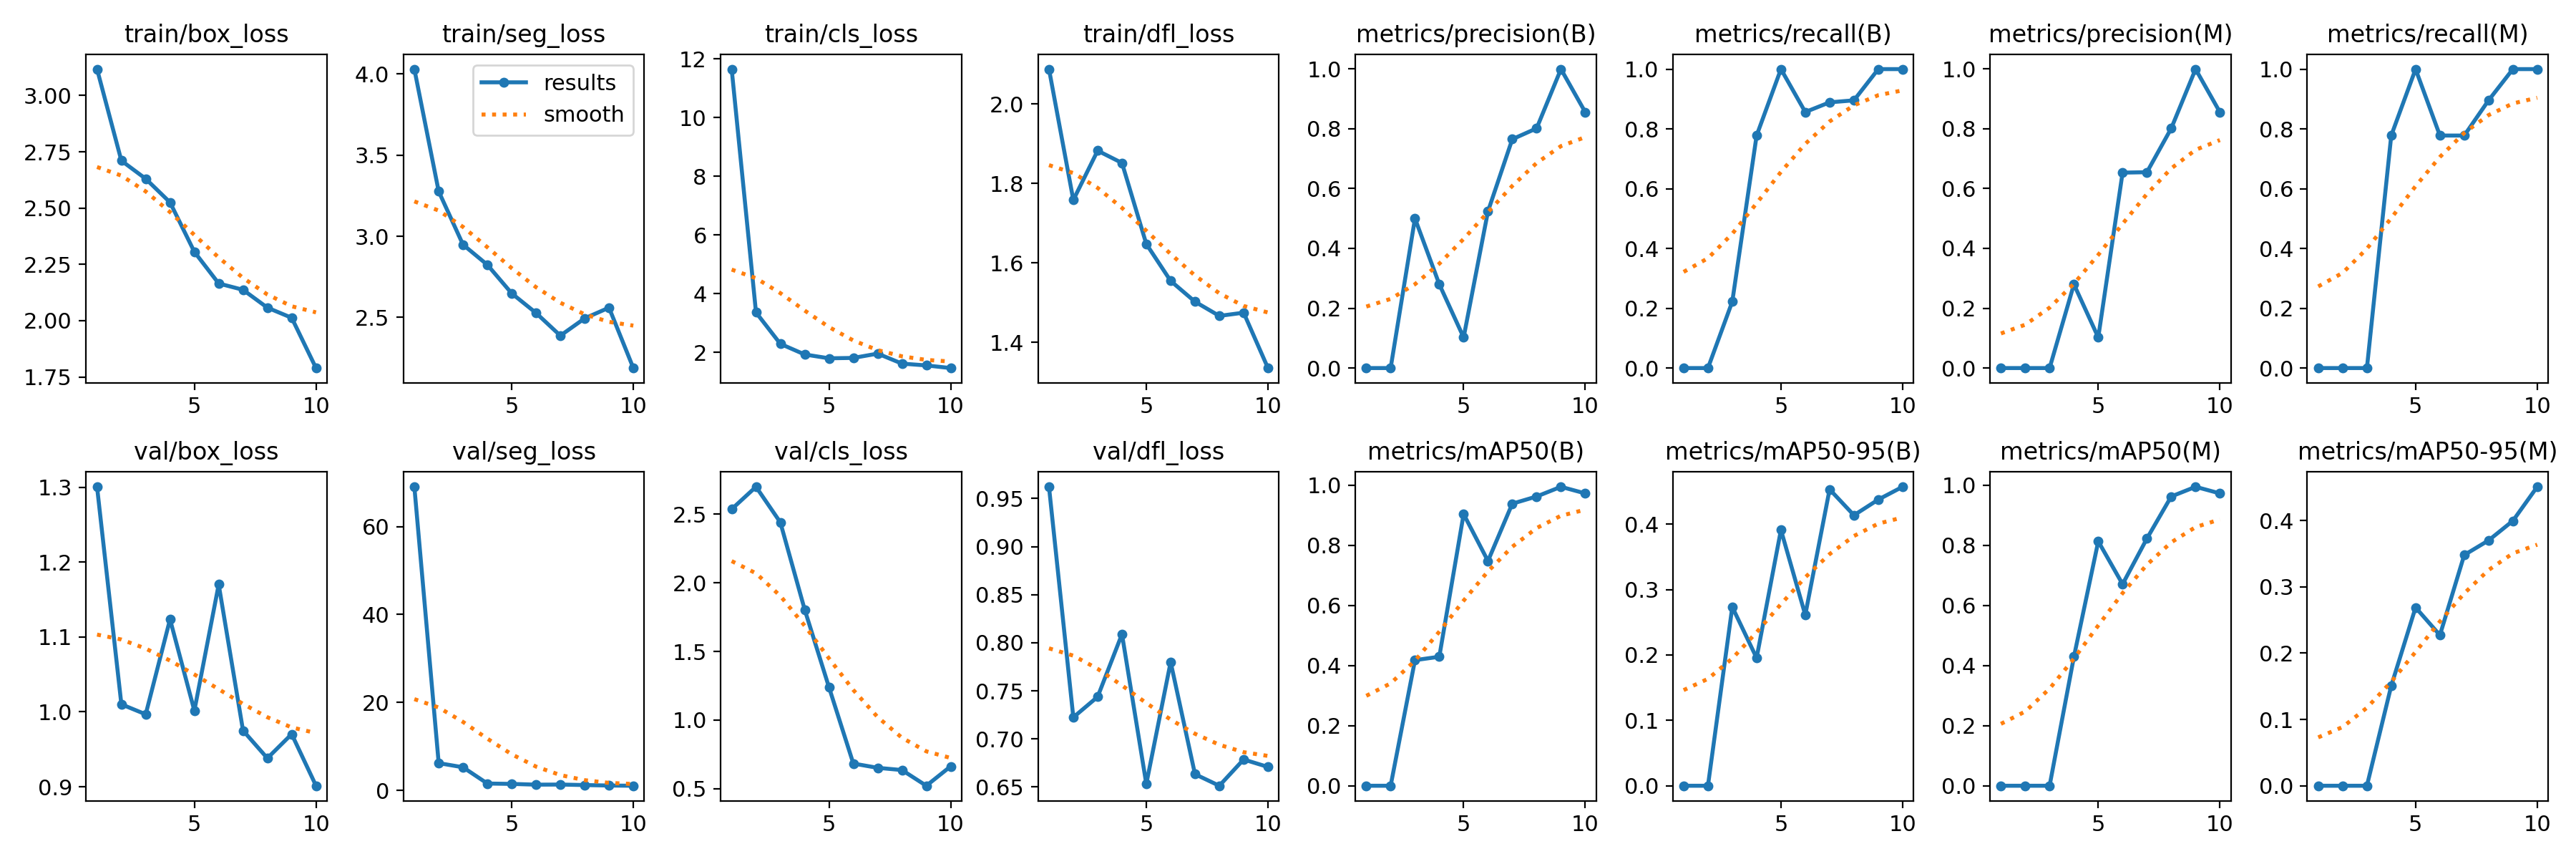

In [ ]:
from google.colab.patches import cv2_imshow

result_chart = cv2.imread('/content/runs/segment/train4/results.png')#, cv2.COLOR_RGB2BGR)
print(result_chart.shape)
cv2_imshow(result_chart)

In [ ]:
print(type(model.names),len(model.names))

print(model.names)

<class 'dict'> 1
{0: 'defect'}


In [ ]:
results = model.predict(source ='/content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test', save=True)


image 1/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test/009.png: 416x416 (no detections), 9.4ms
image 2/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test/021.png: 416x416 (no detections), 9.8ms
image 3/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test/025.png: 416x416 (no detections), 9.7ms
image 4/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test/050.png: 416x416 (no detections), 9.2ms
image 5/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test/069.png: 416x416 (no detections), 9.1ms
image 6/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test/071.png: 416x416 (no detections), 8.9ms
image 7/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class1/images/test/091.png: 416x416 (no detections), 8.9ms
image

In [ ]:
results[-5].boxes.conf.tolist()

[0.3921577036380768, 0.336660236120224]

In [ ]:
_ = accuracy(results)

0.991304347826087


In [ ]:
results = model.predict(source ='/content/DAGM2007_ws/DAGM_dataset/Class1_def', save=True)

def_045.jpg


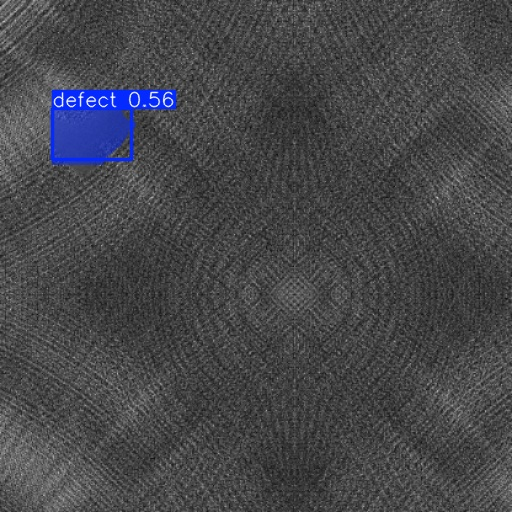

In [ ]:
# 이미지 파일 경로를 가져오기
image_paths = glob.glob('/content/runs/segment/train42/def_*.jpg')

# 이미지가 없는 경우 에러 처리
if not image_paths:
    print("이미지 파일이 없습니다.")
else:
    # 랜덤하게 이미지 선택
    selected_image_path = random.choice(image_paths)

    # 이미지 표시
    print(selected_image_path.split('/')[-1])
    img = cv2.imread(selected_image_path)
    cv2_imshow(img)

## Class2 학습

### lr=0.0005

In [ ]:
from ultralytics import YOLO

# Load a model
# model = YOLO("yolo11n-seg.yaml")  # build a new model from YAML
model = YOLO("yolo11n-seg.pt")  # load a pretrained model (recommended for training)
# model = YOLO("yolo11n-seg.yaml").load("yolo11n.pt")  # build from YAML and transfer weights

In [ ]:
print(type(model.names),len(model.names))

print(model.names)

<class 'dict'> 80
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell p

In [ ]:
model.train(data='/content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class2/data.yaml', epochs= 10, patience = 20, batch=32, imgsz =416, optimizer='Adam', lr0=.0005)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True

train: Scanning /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class2/labels/train... 919 images, 793 backgrounds, 0 corrupt: 100%|██████████| 919/919 [00:02<00:00, 374.02it/s]

train: New cache created: /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class2/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 58.7±12.0 MB/s, size: 199.1 KB)


val: Scanning /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class2/labels/val... 116 images, 107 backgrounds, 0 corrupt: 100%|██████████| 116/116 [00:00<00:00, 399.90it/s]

val: New cache created: /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class2/labels/val.cache


Plotting labels to runs/segment/train5/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/segment/train5
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.51G      4.106      6.745      30.87      2.463          0        416: 100%|██████████| 29/29 [00:12<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all        116          9          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.07G        3.5      4.366      4.025      1.924          4        416: 100%|██████████| 29/29 [00:10<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

                   all        116          9          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.08G      3.191      3.705      2.882      1.688          3        416: 100%|██████████| 29/29 [00:09<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

                   all        116          9          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.11G      3.078      4.031      2.704      1.666          1        416: 100%|██████████| 29/29 [00:10<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

                   all        116          9      0.333      0.111      0.204      0.102          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.11G      3.209      3.948      2.741      1.633          5        416: 100%|██████████| 29/29 [00:10<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all        116          9      0.087      0.667       0.13     0.0394     0.0725      0.556      0.178     0.0526



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.14G       2.77      3.548      2.371      1.478          5        416: 100%|██████████| 29/29 [00:09<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all        116          9     0.0449      0.889      0.372      0.119     0.0449      0.889      0.283     0.0502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.14G        2.4      2.988      2.238      1.306          0        416: 100%|██████████| 29/29 [00:08<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all        116          9      0.347      0.415      0.393      0.133      0.347      0.415      0.367     0.0637



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.17G      2.907      3.568      2.299      1.505          4        416: 100%|██████████| 29/29 [00:10<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all        116          9      0.282      0.667      0.283     0.0973      0.235      0.556      0.261     0.0718



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.18G      2.608      3.876      2.148      1.318          4        416: 100%|██████████| 29/29 [00:10<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all        116          9      0.307      0.667      0.345      0.165      0.356      0.778      0.426      0.132



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10       3.2G      2.483      3.282      2.037      1.271          0        416: 100%|██████████| 29/29 [00:09<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all        116          9      0.412      0.889      0.464      0.135      0.363      0.778      0.473      0.116



10 epochs completed in 0.031 hours.
Optimizer stripped from runs/segment/train5/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train5/weights/best.pt, 6.0MB

Validating runs/segment/train5/weights/best.pt...
Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  4.13it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


                   all        116          9      0.304      0.667      0.345      0.165      0.352      0.778      0.426      0.131
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train5


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ba0b4fa1c90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

(1200, 3600, 3)


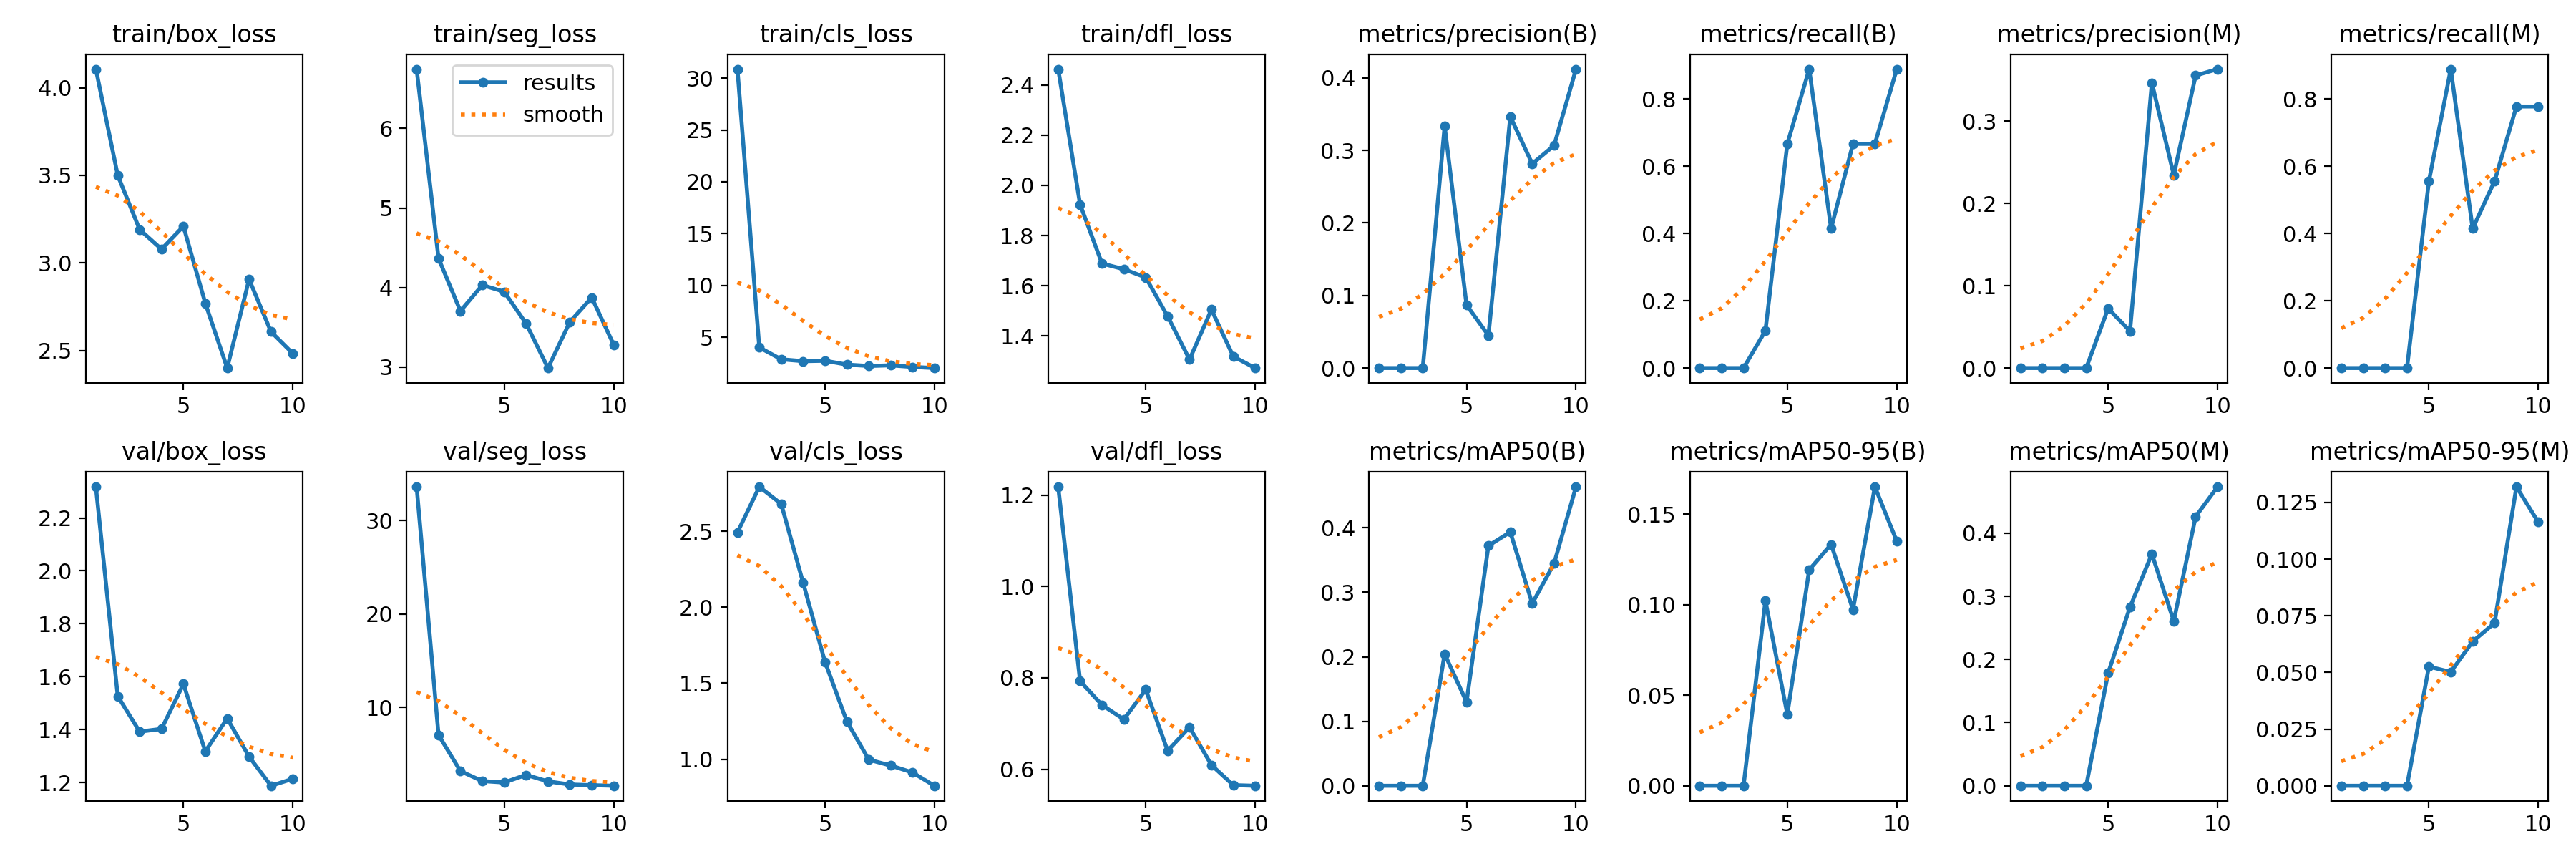

In [ ]:
from google.colab.patches import cv2_imshow

result_chart = cv2.imread('/content/runs/segment/train5/results.png')#, cv2.COLOR_RGB2BGR)
print(result_chart.shape)
cv2_imshow(result_chart)

In [ ]:
print(type(model.names),len(model.names))

print(model.names)

<class 'dict'> 1
{0: 'defect'}


In [ ]:
results = model.predict(source ='/content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class2/images/test', save=True)


image 1/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class2/images/test/009.png: 416x416 (no detections), 11.5ms
image 2/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class2/images/test/021.png: 416x416 (no detections), 9.8ms
image 3/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class2/images/test/025.png: 416x416 (no detections), 9.4ms
image 4/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class2/images/test/050.png: 416x416 (no detections), 9.3ms
image 5/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class2/images/test/069.png: 416x416 (no detections), 9.5ms
image 6/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class2/images/test/071.png: 416x416 (no detections), 9.0ms
image 7/115 /content/DAGM2007_ws/yoloseg_datasets/yoloseg_datasets/yoloseg_dataset_class2/images/test/091.png: 416x416 (no detections), 9.1ms
imag

In [ ]:
_ = accuracy(results)

accuracy = 0.8956521739130435
def only accuracy = 0.2


In [ ]:
results = model.predict(source ='/content/DAGM2007_ws/DAGM_dataset/Class1_def', save=True)

def_071.jpg


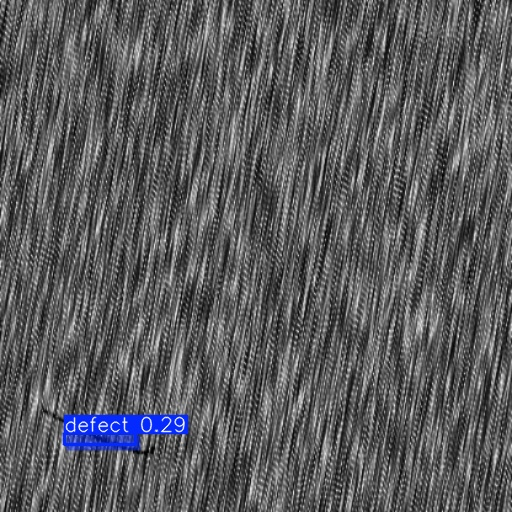

In [ ]:
# 이미지 파일 경로를 가져오기
image_paths = glob.glob('/content/runs/segment/train52/def_*.jpg')

# 이미지가 없는 경우 에러 처리
if not image_paths:
    print("이미지 파일이 없습니다.")
else:
    # 랜덤하게 이미지 선택
    selected_image_path = random.choice(image_paths)

    # 이미지 표시
    print(selected_image_path.split('/')[-1])
    img = cv2.imread(selected_image_path)
    cv2_imshow(img)

# Save Weight

## drive 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## weight 저장

In [ ]:
torch.save(trainer.model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DAGM2007_resnet18_epoch20_lr0.0001.pth')

## weight 불러오기

In [ ]:
loaded_model = torch.load('/content/drive/MyDrive/Colab Notebooks/DAGM2007_resnet18_epoch20_lr0.0001.pth')
!cp /content/drive/MyDrive/Colab\ Notebooks/DAGM2007_resnet18_epoch20_lr0.0001.pth /content/DAGM2007_resnet18_epoch20_lr0.0001.pth